# PII Detection on Collection - MSFT Presidio Example
The following is an example of how to use the PIIAnalysisService with the default MSFT Presidio analyzer on a collection of text.

> Note: This notebook requires all dependencies to have been installed. For more information, review readme.


In [1]:
# Install dependencies
! poetry install
! poetry install --extras="detections"

Installing dependencies from lock file

Package operations: 0 installs, 0 updates, 7 removals

  • Removing phonenumbers (8.13.3): Pending...
  • Removing phonenumbers (8.13.3): Removing...
  • Removing phonenumbers (8.13.3)
  • Removing presidio-analyzer (2.2.31): Pending...
  • Removing presidio-analyzer (2.2.31): Removing...
  • Removing presidio-analyzer (2.2.31)
  • Removing presidio-anonymizer (2.2.31): Pending...
  • Removing presidio-anonymizer (2.2.31): Removing...
  • Removing presidio-anonymizer (2.2.31)
  • Removing pycryptodome (3.16.0): Pending...
  • Removing pycryptodome (3.16.0): Removing...
  • Removing pycryptodome (3.16.0)
  • Removing regex (2022.10.31): Pending...
  • Removing regex (2022.10.31): Removing...
  • Removing regex (2022.10.31)
  • Removing requests-file (1.5.1): Pending...
  • Removing requests-file (1.5.1): Removing...
  • Removing requests-file (1.5.1)
  • Removing tldextract (3.4.0): Pending...
  • Removing tldextract (3.4.0): Removing...
  • Remov

In [10]:
from pii_codex.services.analysis_service import PIIAnalysisService
import pandas as pd

pii_analysis_service = PIIAnalysisService()

# Run the detection and assessments in one shot with the PIIAnalysisService
analysis_results = pii_analysis_service.analyze_collection(
    texts=[
        "How can I reach you, Jim?",
        "As a democrat, I promise to uphold....",
        "As a Catholic, I can tell you that....",
        "Here is my contact information: Phone number 555-555-5555 and my email is example123@email.com",
        "Perfect, my number if you need me is 777-777-7777. Where is the residence and what is the earliest the crew can arrive?",
        "I'll be at my home at 123 Dark Data Lane, OH, 11111 after 7PM",
        "Cool, I'll be there!"
        ],
    collection_type="population",
    collection_name="PII Collection 1"
)

print("Collection Risk Score: ", analysis_results.risk_score_mean)
analysis_results.detected_pii_type_frequencies

Collection Risk Score:  2.238095238095238


Counter({'PERSON': 1,
         'NRP': 2,
         'EMAIL_ADDRESS': 1,
         'PHONE_NUMBER': 2,
         'URL': 1,
         'LOCATION': 1})

Sometimes text analyses aren't enough. For those handling social media records, they may be provided with metadata that can be used in determining if the post contains other elements considered to be PII. For this, we expose a data parameter. Pass in a data frame with a text column (str) and a metadata column (dict) for each social media post. You could also pass in the individual text entry instead of passing in the metadata dict as shown below.

In [3]:

analysis_results = pii_analysis_service.analyze_collection(
    data=pd.DataFrame.from_dict({
        "text": [
            "I attend the University of Central Florida, how about you?",
            "As a democrat, I promise to uphold....",
            "As a Catholic, I can tell you that....",
            "If anyone needs trig help, my phone number 555-555-5555 and my email is example123@email.com",
            "Oh I do! My number is 777-777-7777. Where is the residence hall?",
            "The dorm is over at 123 Dark Data Lane, OH, 11111",
            "Cool, I'll be there!"
        ],
        "metadata": [
            {"location": True, "url": False, "screen_name": True},
            {"location": True, "url": False, "screen_name": True},
            {"location": True, "url": False, "screen_name": True},
            {"location": True, "url": False, "screen_name": True},
            {"location": False, "url": False, "screen_name": True}, # Not all social media posts will have location metadata
            {"location": False, "url": False, "screen_name": True},
            {"location": True, "url": False, "screen_name": True},
        ]
    }),
    collection_type="population",
    collection_name="PII Collection 1"
)

results = analysis_results.to_dict()
results

{'collection_name': 'PII Collection 1',
 'collection_type': 'POPULATION',
 'analyses': [{'analysis': [{'pii_type_detected': None,
     'risk_level': 1,
     'risk_level_definition': 'Non-Identifiable',
     'cluster_membership_type': None,
     'hipaa_category': None,
     'dhs_category': None,
     'nist_category': None},
    {'pii_type_detected': 'LOCATION',
     'risk_level': 2,
     'risk_level_definition': 'Semi-Identifiable',
     'cluster_membership_type': 'Secure Identifiers',
     'hipaa_category': 'Protected Health Information',
     'dhs_category': 'Not Mentioned',
     'nist_category': 'Linkable',
     'entity_type': 'LOCATION',
     'score': 0.0,
     'start': 0,
     'end': 0},
    {'pii_type_detected': 'SCREEN_NAME',
     'risk_level': 3,
     'risk_level_definition': 'Identifiable',
     'cluster_membership_type': 'Personal Preferences',
     'hipaa_category': 'Not Protected Health Information',
     'dhs_category': 'Not Mentioned',
     'nist_category': 'Directly PII',

For those in need to store off the data but do not wish to have the raw text stored, the library leverages Microsoft Presidio to sanitize the input text, redacting the detected items from the original analysis. The redactions are entirely configurable within the `presidio_analysis.py` file.

In [4]:
sanitized_texts = [result["sanitized_text"] for result in results["analyses"]]
sanitized_texts

['I attend the University of Central Florida, how about you?',
 'As a <REDACTED>, I promise to uphold....',
 'As a <REDACTED>, I can tell you that....',
 'If anyone needs trig help, my phone number <REDACTED> and my email is <REDACTED>',
 'Oh I do! My number is <REDACTED>. Where is the residence hall?',
 'The dorm is over at 123 Dark Data Lane, <REDACTED>, 11111',
 "Cool, I'll be there!"]

In [5]:
# Peering into each and every analysis in collection
data = results.copy()
del data['analyses']

analyses_collection_df = pd.DataFrame(
    [data]
)

analyses_collection_df.T

,0
collection_name,PII Collection 1
collection_type,POPULATION
detection_count,21
risk_scores,"[2, 2.3333333333333335, 2.3333333333333335, 2...."
risk_score_mean,2.395238
risk_score_mode,2
risk_score_median,2.333333
risk_score_standard_deviation,0.324858
risk_score_variance,0.105533
detected_pii_types,"{SCREEN_NAME, LOCATION, URL, EMAIL_ADDRESS, NR..."


In [6]:
analyses = results["analyses"]
analyses_df = pd.DataFrame(
    analyses
)
analyses_df["collection_name"] = results["collection_name"]
analyses_df

,analysis,index,risk_score_mean,sanitized_text,collection_name
0,"[{'pii_type_detected': None, 'risk_level': 1, ...",0,2.000000,"I attend the University of Central Florida, ho...",PII Collection 1
1,"[{'pii_type_detected': 'NRP', 'risk_level': 2,...",1,2.333333,"As a <REDACTED>, I promise to uphold....",PII Collection 1
2,"[{'pii_type_detected': 'NRP', 'risk_level': 2,...",2,2.333333,"As a <REDACTED>, I can tell you that....",PII Collection 1
3,"[{'pii_type_detected': 'EMAIL_ADDRESS', 'risk_...",3,2.600000,"If anyone needs trig help, my phone number <RE...",PII Collection 1
4,"[{'pii_type_detected': 'PHONE_NUMBER', 'risk_l...",4,3.000000,Oh I do! My number is <REDACTED>. Where is the...,PII Collection 1
5,"[{'pii_type_detected': 'LOCATION', 'risk_level...",5,2.500000,"The dorm is over at 123 Dark Data Lane, <REDAC...",PII Collection 1
6,"[{'pii_type_detected': None, 'risk_level': 1, ...",6,2.000000,"Cool, I'll be there!",PII Collection 1


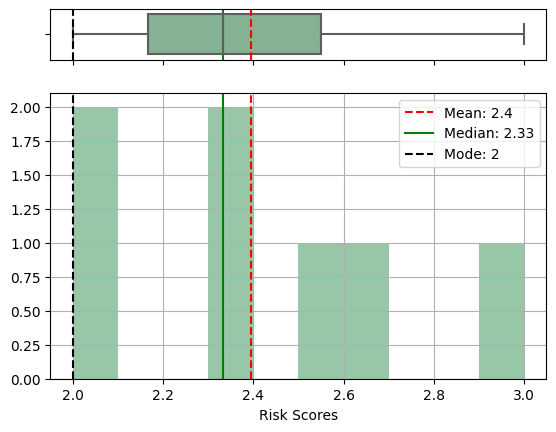

In [13]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_palette(sns.color_palette("crest"))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

mean=analyses_collection_df['risk_score_mean'].item()
median=analyses_collection_df['risk_score_median'].item()
mode=analyses_collection_df['risk_score_mode'].item()

sns.boxplot(data=analyses_df, x="risk_score_mean", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='green', linestyle='-')
ax_box.axvline(mode, color='black', linestyle='--')

ax_hist.hist(analyses_collection_df["risk_scores"], alpha = 0.8)
ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean: {round(mean, 2)}")
ax_hist.axvline(median, color='green', linestyle='-', label=f"Median: {round(median, 2)}")
ax_hist.axvline(mode, color='black', linestyle='--', label=f"Mode: {mode}")

ax_hist.set(xlabel='Risk Scores')
ax_hist.legend()

ax_box.set(xlabel='')
plt.grid()
plt.show()

In [8]:
detected_types = []
for detection in analyses_collection_df["detected_pii_type_frequencies"].item():
    detected_types.append({
        "Collection": analyses_collection_df["collection_name"].item(),
        "Detected PII Type": detection,
        "Count": analyses_collection_df["detected_pii_type_frequencies"].item()[detection]
    })

detected_types_df = pd.DataFrame(detected_types)
detected_types_df

,Collection,Detected PII Type,Count
0,PII Collection 1,LOCATION,6
1,PII Collection 1,SCREEN_NAME,7
2,PII Collection 1,NRP,2
3,PII Collection 1,EMAIL_ADDRESS,1
4,PII Collection 1,PHONE_NUMBER,2
5,PII Collection 1,URL,1


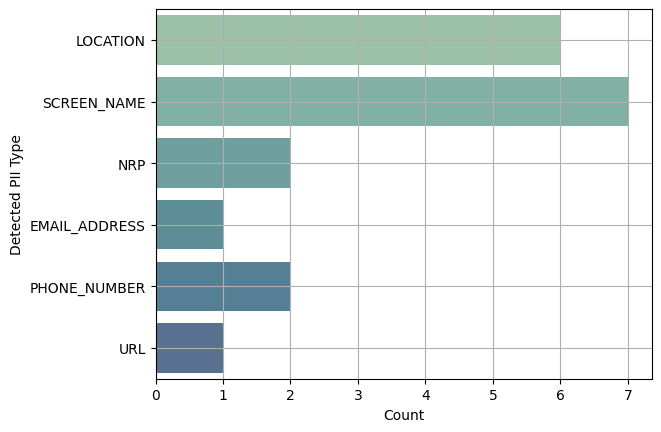

In [12]:
sns.barplot(data=detected_types_df, y="Detected PII Type", x="Count", alpha = 0.8)
plt.grid()